Interpretable Machine Learning Models of Chemometric Trends in Seabirds of the North Pacific Ocean
===

Author: Nathan A. Mahynski

Date: 2024/07/09

Description: Identifying chemometric trends in seabird eggs using interpretable machine learning models.  Here, the focus is on discrimination since samples (eggs) are known to be collected from a fixed set of animal species, and always will be.  This is because these species and locations were predetermined for monitoring.  Moreover, it is more important to have simple models that are scientifically insightful, than opaque black box models, which may perform better but are harder to understand.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/applications/2023_stamp.ipynb)

This is based on [Mahynski, N.A., Ragland, J.M., Schuur, S.S. et al. Building Interpretable Machine Learning Models to Identify Chemometric Trends in Seabirds of the North Pacific Ocean. Env. Sci. & Tech. 56, 14361–14374 (2022). https://doi.org/10.1021/acs.est.2c01894](https://doi.org/10.1021/acs.est.2c01894)

~~~code
@article{mahynski2022building,
  title={Building Interpretable Machine Learning Models to Identify Chemometric Trends in Seabirds of the North Pacific Ocean},
  author={Mahynski, Nathan A and Ragland, Jared M and Schuur, Stacy S and Shen, Vincent K},
  journal={Environmental Science \& Technology},
  volume={56},
  number={20},
  pages={14361--14374},
  year={2022},
  publisher={ACS Publications}
}
~~~

Also see the associated [GitHub repository](https://github.com/mahynski/stamp-dataset-1999-2010).

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [4]:
import imblearn

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay

from mpl_toolkits.mplot3d import Axes3D

from pychemauth.datasets import load_stamp2010
from pychemauth.preprocessing.imbalanced import ScaledSMOTEENN
from pychemauth.preprocessing.feature_selection import JensenShannonDivergence,CollinearFeatureSelector
from pychemauth.analysis.compare import BiasedNestedCV
from pychemauth.eda.screen import JSBinary, JSScreen
from pychemauth.eda.explore import InspectData

In [5]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

matplotlib: 3.7.2
seaborn   : 0.12.2
watermark : 2.4.3
imblearn  : 0.11.0
pychemauth: 0.0.0b4
pandas    : 1.5.3
numpy     : 1.24.3



<h3>Load the Data</h3>

In [6]:
# You will need an active internet connection - this function loads the data directly from the GitHub repo above.
data_bunch = load_stamp2010()

In [7]:
data_bunch.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'frame', 'DESCR'])

In [8]:
data_bunch['DESCR']

"Dataset reported in Schuur, Stacy S., Ragland, Jared M., Mahynski, Nathan A. (2021), Data Supporting 'Seabird Tissue Archival and Monitoring Project (STAMP) Data from 1999-2010', National Institute of Standards and Technology, https://doi.org/10.18434/mds2-2431 . See this publication for a full description."

In [9]:
title_size, label_size, tick_size = 16, 14, 12

# Modeling Genus

Label the Data
---

In [10]:
X = pd.DataFrame(data=data_bunch['data'], columns=data_bunch['feature_names'], dtype=np.float64)
y = pd.DataFrame(data=data_bunch['target'][:,2], columns=['Common Name'])

def genus(name):
    if ('gull' in name):
        return r'${\it Larus}$ (gull)'
    elif ('murre' in name):
        return r'${\it Uria}$ (murre)'
    elif ('albatross' in name):
        return r'${\it Phoebastria}$ (albatross)'
    else:
        raise Exception('unexpected value')

y = y['Common Name'].apply(genus)

Examine the Class Imbalance
---

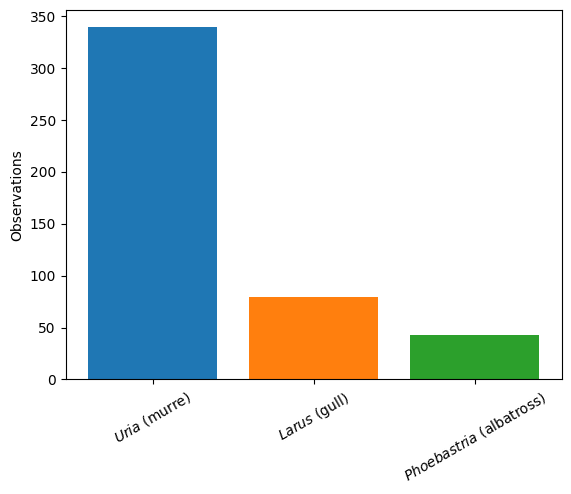

In [11]:
plt.bar(
    x=y.unique(),
    height=[np.sum(y==c) for c in y.unique()],
    color=['C0', 'C1', 'C2'],
)
plt.ylabel('Observations')
_ = plt.xticks(rotation=30)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

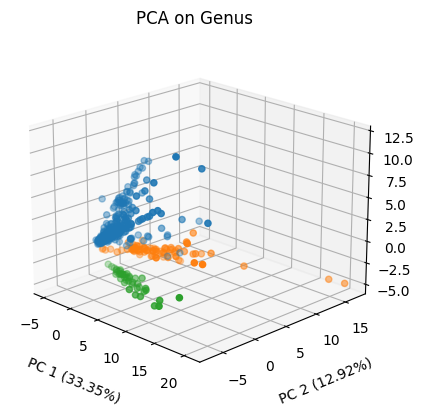

In [20]:
%matplotlib inline

pca = PCA(n_components=3)
ss = StandardScaler()
X_proj = pca.fit_transform(ss.fit_transform(X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for bird in y.unique():
    mask = y == bird
    ax.scatter(X_proj[mask,0], X_proj[mask,1], X_proj[mask,2], label=bird)

ax.set_xlabel('PC 1 ({}%)'.format('%.2f'%(pca.explained_variance_ratio_[0]*100)),
              labelpad=10)
ax.set_ylabel('PC 2 ({}%)'.format('%.2f'%(pca.explained_variance_ratio_[1]*100)),
              labelpad=10)
ax.set_zlabel('PC 3 ({}%)'.format('%.2f'%(pca.explained_variance_ratio_[2]*100)),
              labelpad=10)
ax.set_title('PCA on Genus')
ax.view_init(elev=20., azim=-45)

ax.tick_params(axis='x', which='major')
ax.tick_params(axis='y', which='major')
ax.tick_params(axis='z', which='major')

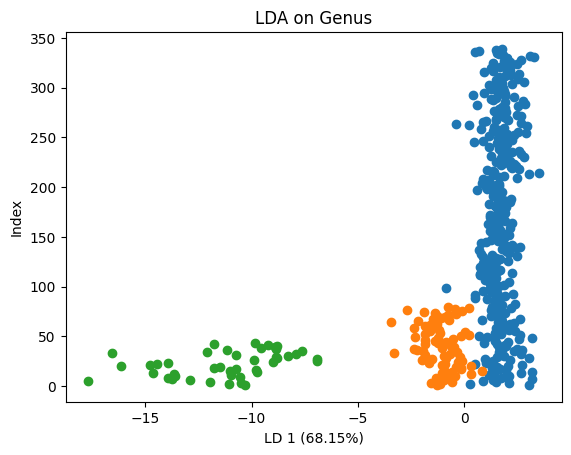

In [21]:
%matplotlib inline

lda = LDA(n_components=1, store_covariance=True)
ss = StandardScaler()
X_proj = lda.fit_transform(ss.fit_transform(X), y)

fig, ax = plt.subplots()

for bird in y.unique():
    mask = y == bird
    ax.plot(X_proj[mask,0], np.arange(1,1+X_proj[mask].shape[0]), 'o',
             label=bird)
plt.xlabel('LD 1 ({}%)'.format('%.2f'%(lda.explained_variance_ratio_[0]*100)))
plt.ylabel('Index')
plt.title('LDA on Genus')
plt.tick_params(axis='x', which='major')
plt.tick_params(axis='y', which='major')

A Decision Tree Would Be Simpler
---

In [22]:
# KFold CV on entire dataset to build production model

pipeline = imblearn.pipeline.Pipeline(steps=[
    ("smote", ScaledSMOTEENN(random_state=1)),
    ('tree', DecisionTreeClassifier(random_state=1))
])

param_grid = [
    {
     'smote__k_enn':[3, 5, 7, 10],
     'smote__k_smote':[3, 5, 7, 10],
     'smote__kind_sel_enn':['all', 'mode'],
     'tree__max_depth':np.arange(1,4+1),
    }]

gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  n_jobs=-1,
                  refit=True, # Refit on all the data
                  cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True))

enc = LabelEncoder()

gs.fit(X.values, enc.fit_transform(y.values))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('smote',
                                        <pychemauth.preprocessing.imbalanced.ScaledSMOTEENN object at 0x7cc3540112a0>),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'smote__k_enn': [3, 5, 7, 10],
                          'smote__k_smote': [3, 5, 7, 10],
                          'smote__kind_sel_enn': ['all', 'mode'],
                          'tree__max_depth': array([1, 2, 3, 4])}])

In [23]:
gs.best_params_

{'smote__k_enn': 3,
 'smote__k_smote': 5,
 'smote__kind_sel_enn': 'all',
 'tree__max_depth': 3}

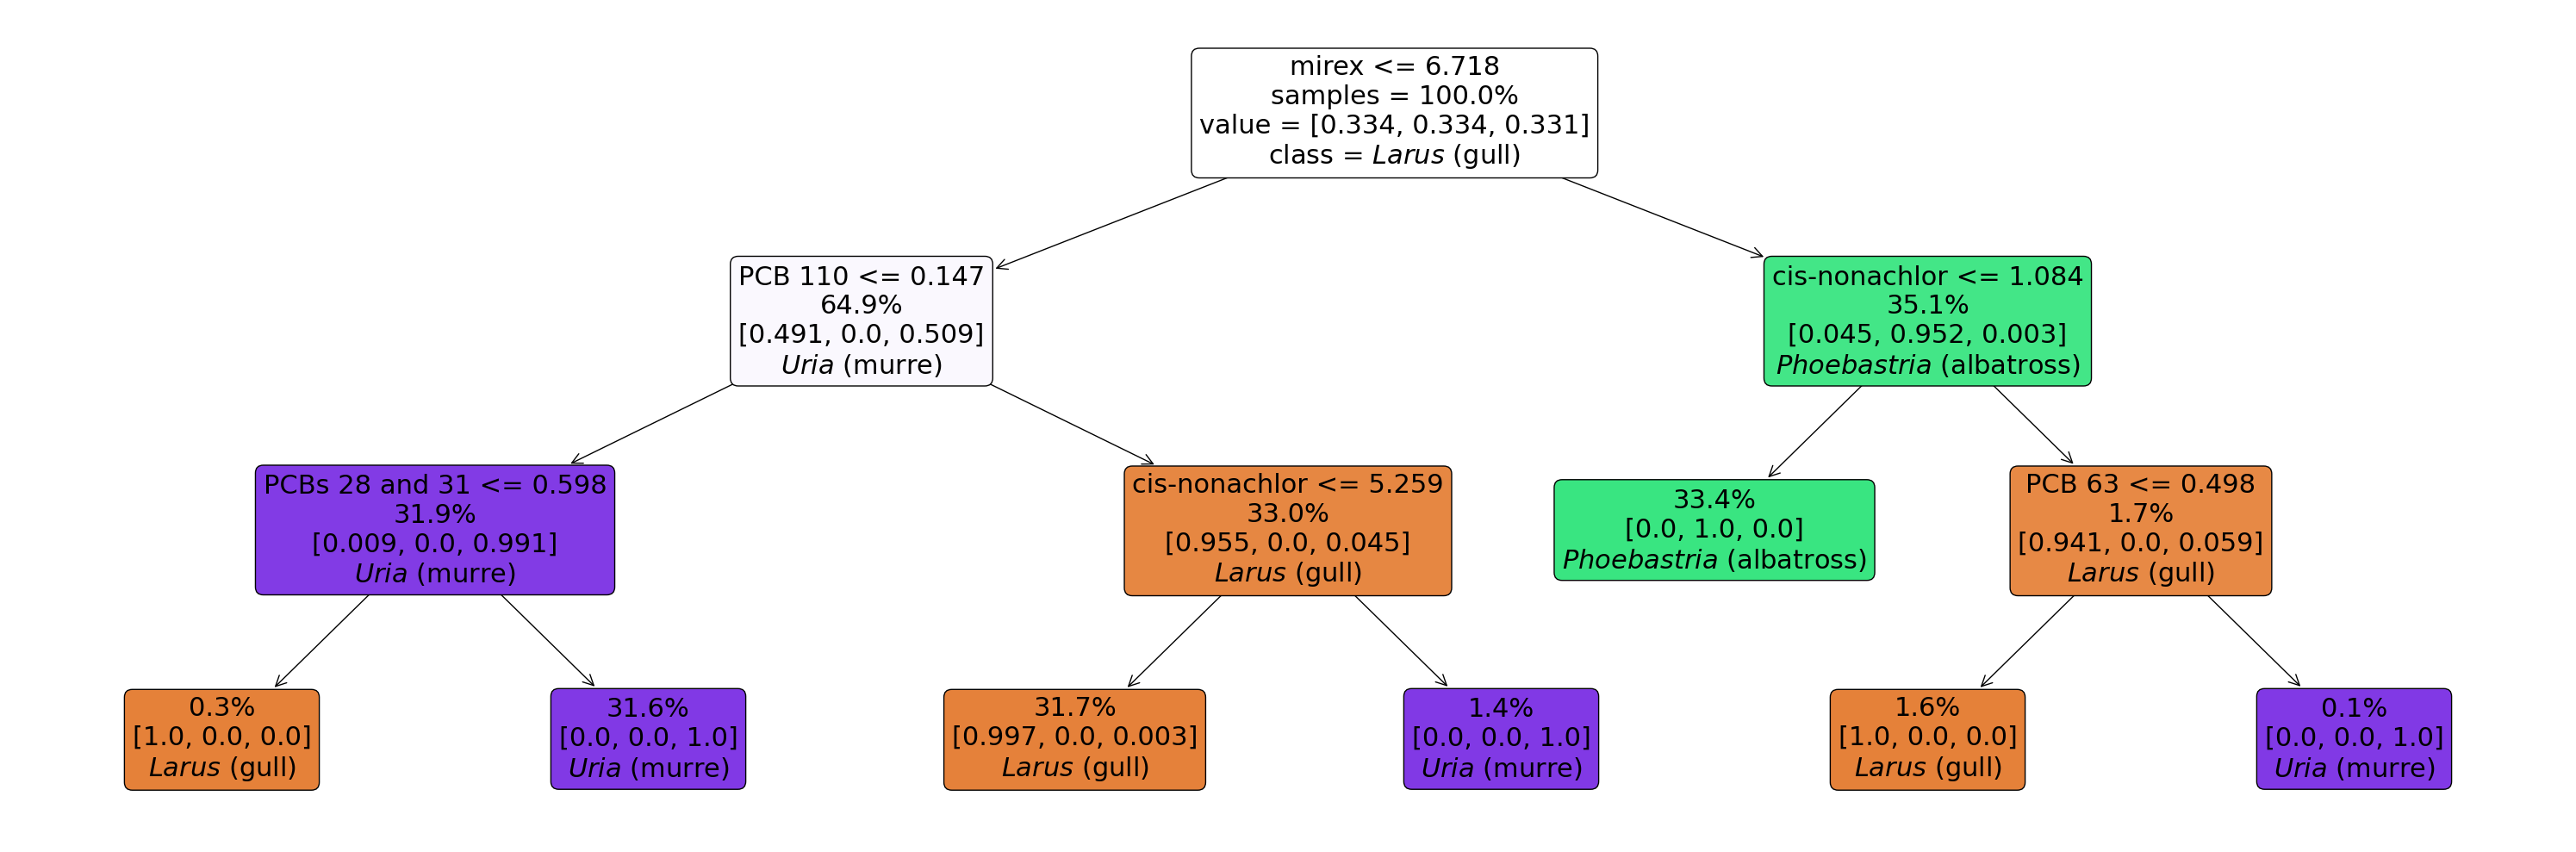

In [24]:
tree = gs.best_estimator_.named_steps['tree']

fig = plt.figure(figsize=(30,10))
_ = plot_tree(
    tree,
    feature_names=X.columns.tolist(),
    class_names=enc.classes_.tolist(),
    label='root',
    filled=True,
    proportion=True,
    impurity=False,
    ax=fig.gca(),
    fontsize=22,
    rounded=True
)
plt.tight_layout()

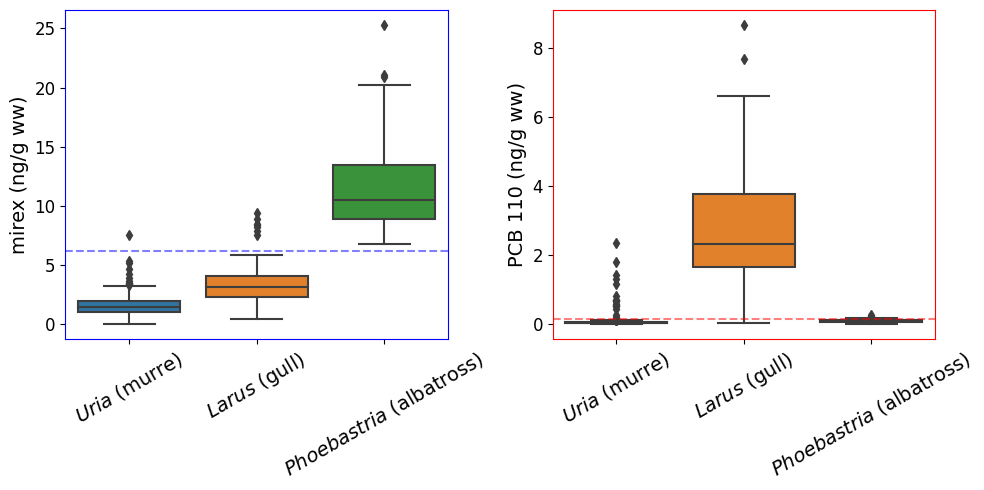

In [25]:
# Mirex and PCB 110 are predominantly responsible for splitting the data into the 3 genera.

X_net = X.copy()
X_net['genus'] = y

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i,((a,l,c),ax) in enumerate(zip(
    [('mirex', 6.178, 'b'), ('PCB 110', 0.147, 'r')],
    axes.ravel()
)):
    ax_ = sns.boxplot(x='genus', y=a, data=X_net, ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    ax.spines["top"].set_color(c)
    ax.spines["bottom"].set_color(c)
    ax.spines["left"].set_color(c)
    ax.spines["right"].set_color(c)
    ax.axhline(l, color=c, alpha=0.5, linestyle='--')
    _ = ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, fontsize=label_size)
    _ = ax_.set_ylabel(a+' (ng/g ww)', fontsize=label_size)
    _ = ax.set_xlabel('')
plt.tight_layout()

But is there anything special about the mirex / PCB 110 or are there other analytes that are also as discriminating?  We can use Jensen-Shannon divergences to gain insight.

In [26]:
js = JensenShannonDivergence(top_k=3, per_class=True,
                             feature_names=X.columns,
                             bins=25,
                             robust=False,
                             epsilon=1.0e-12)
_ = js.fit(X,y)

<ipython-input-27-ecff026b0af5>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax_.set_xticklabels(xv, rotation=90)


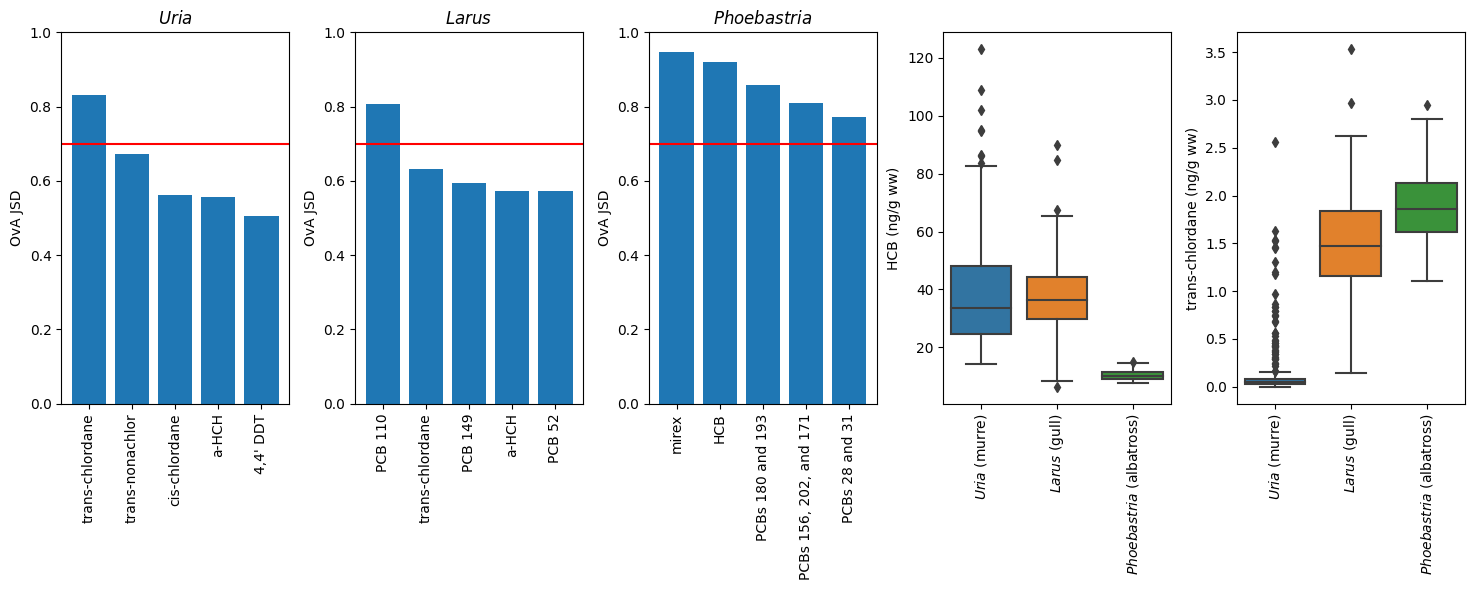

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,6))

for (class_, label), ax_ in zip([('${\\it Uria}$ (murre)', '${\\it Uria}$'),
                                 ('${\\it Larus}$ (gull)', '${\\it Larus}$'),
                                 ('${\\it Phoebastria}$ (albatross)', '${\\it Phoebastria}$')],
                       axes.flatten()
                      ):
    xv = [a[0] for a in js.divergence[class_]]
    yv = [a[1][class_] for a in js.divergence[class_]]
    ax_.tick_params(axis='y', which='major')
    ax_.set_ylim(0,1)
    ax_.set_title(label)
    ax_.set_ylabel('OvA JSD')
    ax_.bar(x=xv[:5], height=yv[:5])
    ax_.axhline(0.7, color="r")
    _ = ax_.set_xticklabels(xv, rotation=90)
plt.tight_layout()

class_ = '${\\it Phoebastria}$ (albatross)'
ax_ = sns.boxplot(x='genus', y='HCB', data=X_net, ax=axes[3])
_ = ax_.set_xticklabels(ax_.get_xticklabels(),rotation=90)
ax_.set_xlabel('')
ax_.set_ylabel('HCB (ng/g ww)')
ax_.tick_params(axis='y', which='major')

class_ = '${\\it Uria}$ (murre)'
ax_ = sns.boxplot(x='genus', y='trans-chlordane', data=X_net, ax=axes[4])
_ = ax_.set_xticklabels(ax_.get_xticklabels(), rotation=90)
ax_.set_xlabel('')
ax_.set_ylabel('trans-chlordane (ng/g ww)')
ax_.tick_params(axis='y', which='major')

It turns out PCB 110 distinguishes Larus from the other 2 very well; there are many things that distinguish Phoebastria but mirex is the leading feature.  To separate 3 classes we only need 2 features to split on, so this is what the trees used.  In fact, we can probably (1) get away with just using these 2 features, and (2) build very similarly performing models with other analytes with similar one-vs-all (OvA) JSD values.

In [28]:
def train_small_tree(features):
    pipeline = imblearn.pipeline.Pipeline(
        steps=[
            ("smote", ScaledSMOTEENN(random_state=1)),
            ('tree', DecisionTreeClassifier(random_state=1))
        ]
    )

    param_grid = [
        {
            'smote__k_enn':[3, 5, 7, 10],
            'smote__k_smote':[3, 5, 7, 10],
            'smote__kind_sel_enn':['all', 'mode'],
            'tree__max_leaf_nodes':[3]
        }
    ]

    # Fit on the entire set using 10-fold
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        refit=True, # Refit on all the data
        cv=StratifiedKFold(
            n_splits=10,
            random_state=1,
            shuffle=True
        )
    )

    # Encode labels as integers for fitting
    enc= LabelEncoder()
    y_ = enc.fit_transform(y.values)
    _ = gs.fit(X[features].values,
               y_)

    # Plot the tree
    fig = plt.figure(figsize=(20,7))
    _ = plot_tree(
        gs.best_estimator_.named_steps['tree'],
        feature_names=features,
        class_names=enc.classes_.tolist(),
        filled=True,
        proportion=True,
        label='root',
        impurity=False,
        ax=fig.gca(),
        fontsize=22,
        rounded=True
    )
    plt.tight_layout()

    # Estimate generalization performance
    ncv = BiasedNestedCV(k_inner=10, k_outer=10)
    approx_performance = ncv.grid_search(
        pipeline,
        param_grid,
        X[features].values,
        y_
    )

    return approx_performance

Approximate performance: 96.24% +/- 2.63%


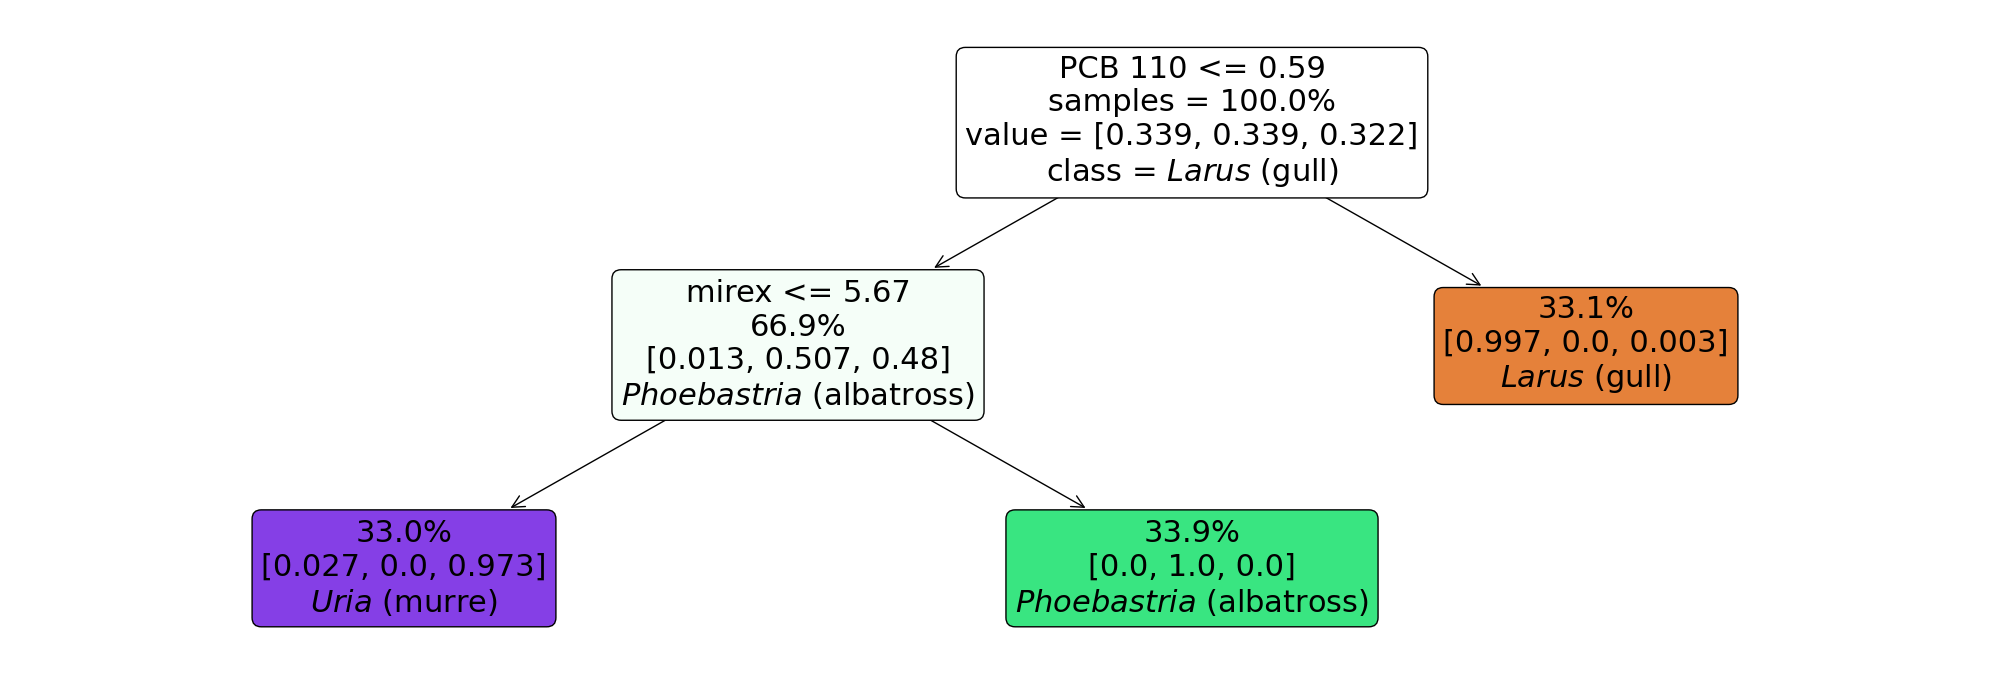

In [29]:
performance = train_small_tree(features=['PCB 110', 'mirex'])
print('Approximate performance: {}% +/- {}%'.format('%.2f'%(100*np.mean(performance)), '%.2f'%(100*np.std(performance))))

Approximate performance: 95.53% +/- 2.95%


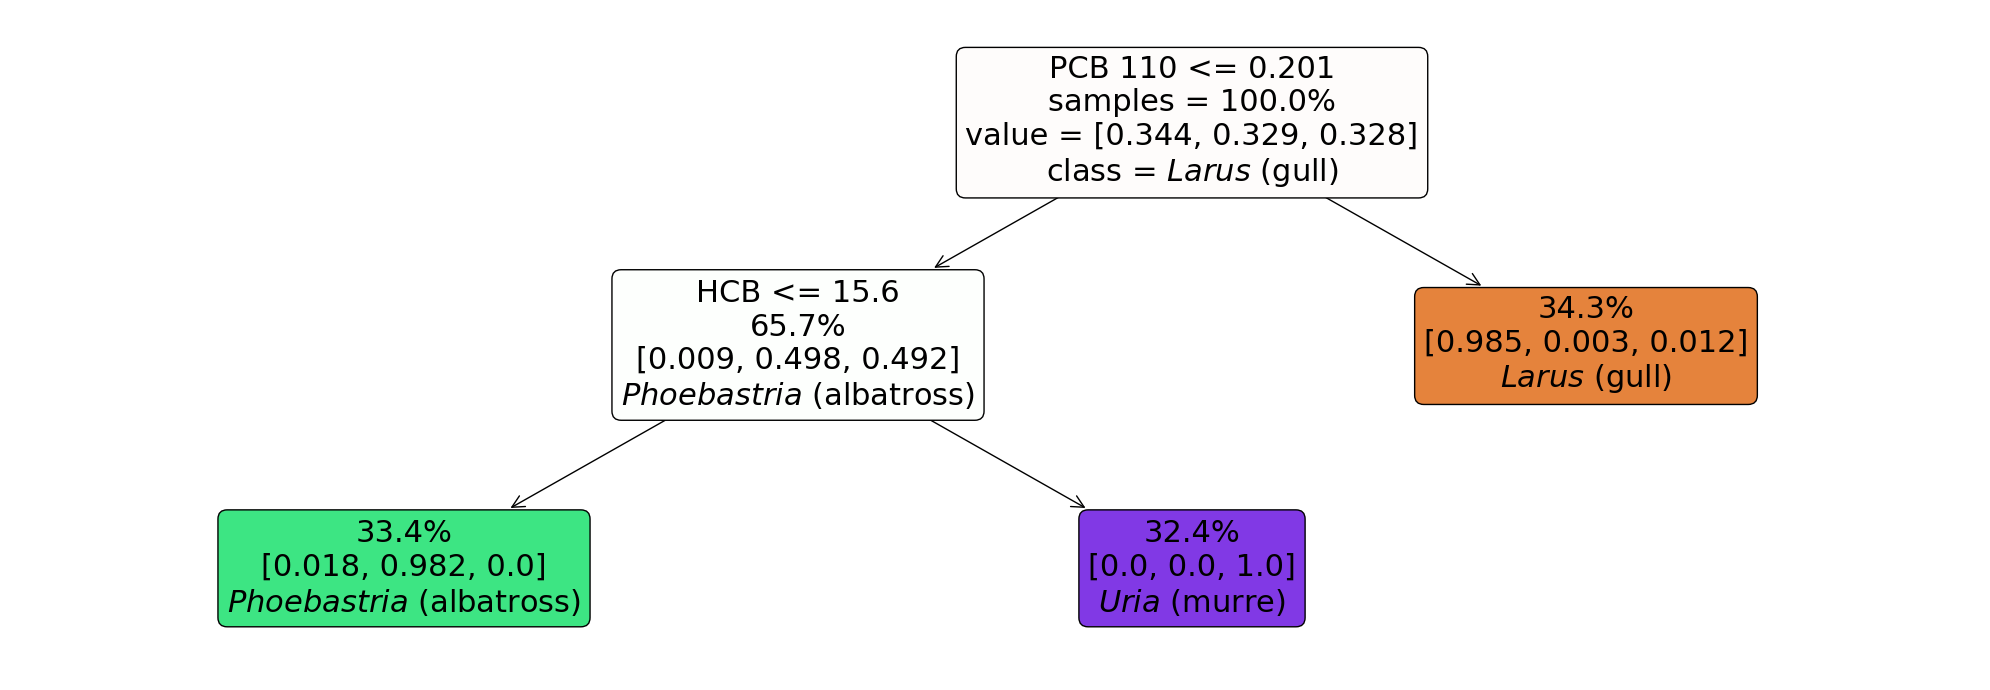

In [30]:
# We can swap mirex for HCB and we get a similar peformance.
performance = train_small_tree(features=['PCB 110', 'HCB'])
print('Approximate performance: {}% +/- {}%'.format('%.2f'%(100*np.mean(performance)), '%.2f'%(100*np.std(performance))))

Approximate performance: 95.61% +/- 2.76%


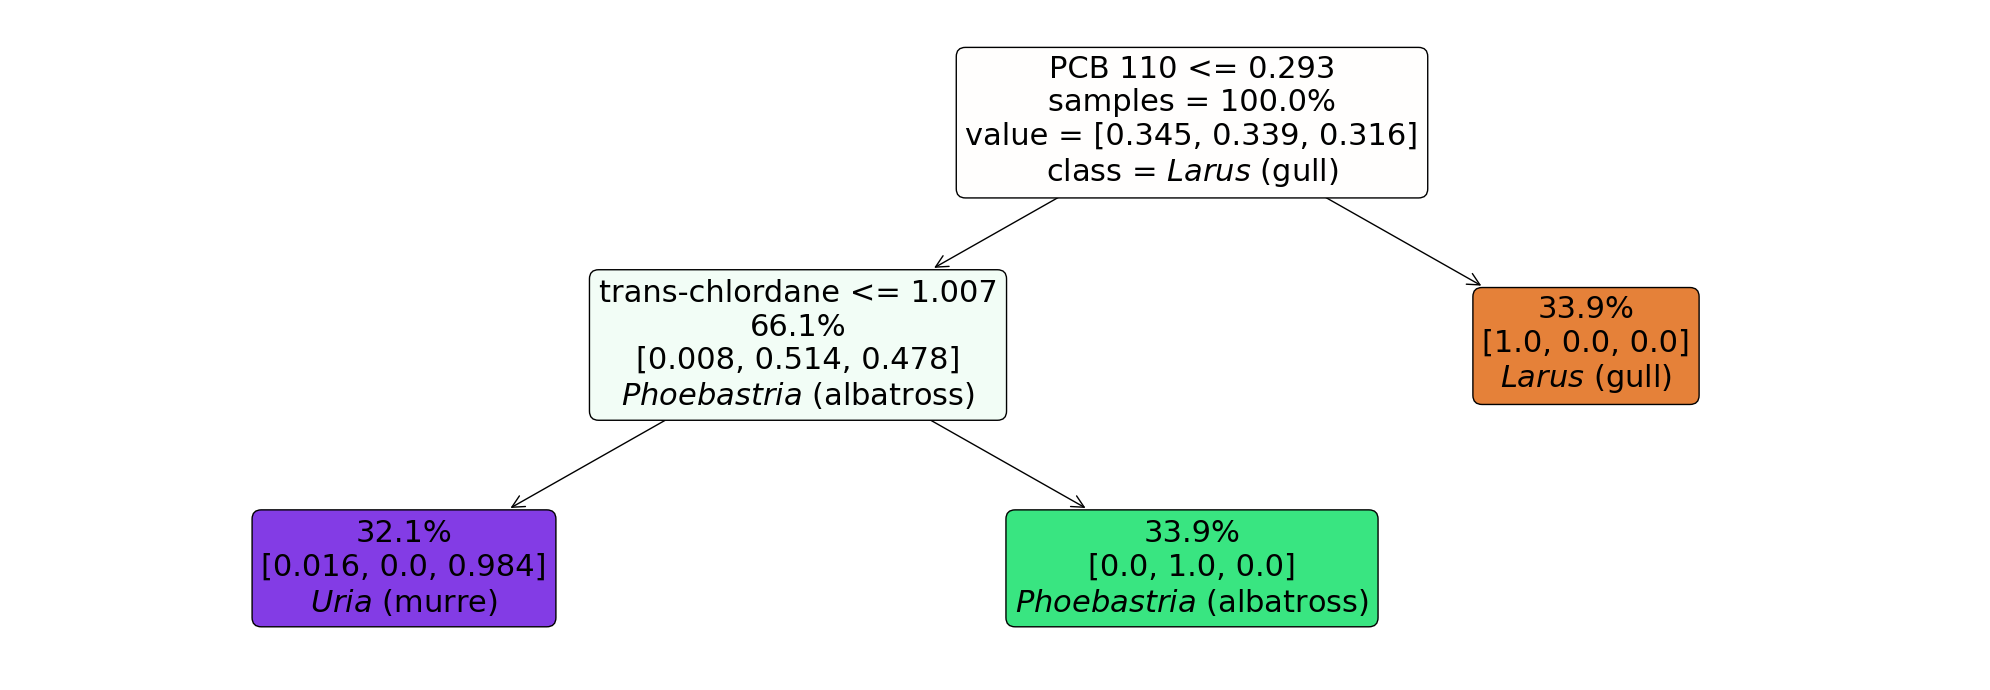

In [31]:
# We can also use features that discriminate for Uria+Larus instead of Phoebastria+Larus
performance = train_small_tree(features=['PCB 110', 'trans-chlordane'])
print('Approximate performance: {}% +/- {}%'.format('%.2f'%(100*np.mean(performance)), '%.2f'%(100*np.std(performance))))

Approximate performance: 93.30% +/- 3.40%


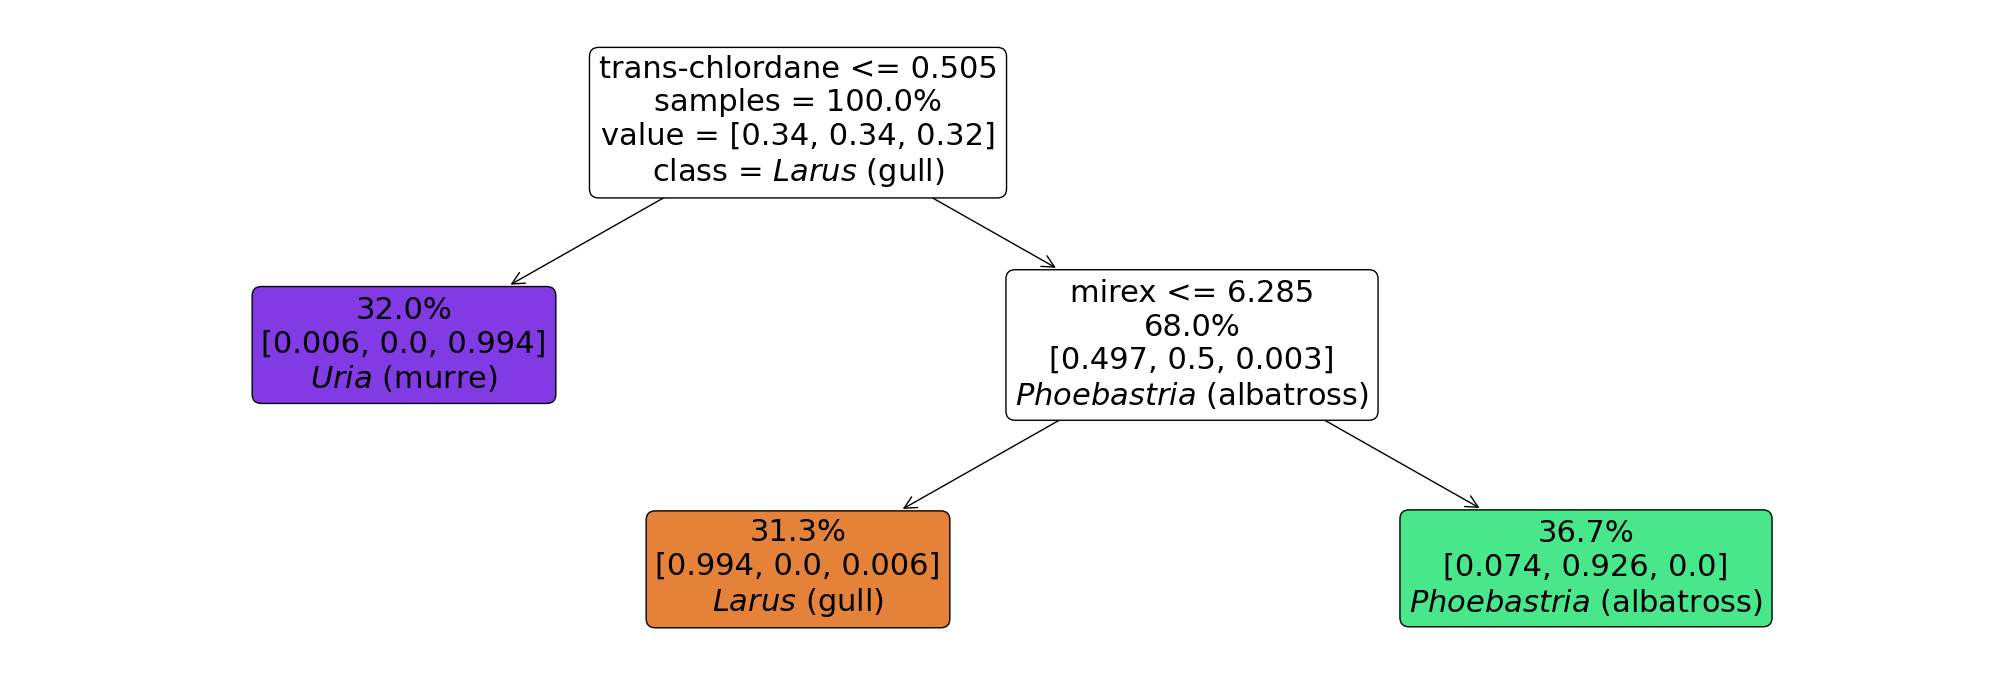

In [32]:
# Similarly, se can also use features that discriminate for Uria+Phoebastria.
performance = train_small_tree(features=['mirex', 'trans-chlordane'])
print('Approximate performance: {}% +/- {}%'.format('%.2f'%(100*np.mean(performance)), '%.2f'%(100*np.std(performance))))

# Modeling Species

In principle, since genus was very simple to accurately model we might expect that species would be as well.  This dataset has 2 species per genus in the Larus and Uria genera, and just 1 in the Phoebastria.  So we really just need to divide the Larus and Uria nodes to accomplish this!

Label the Data
---

In [33]:
X = pd.DataFrame(data=data_bunch['data'], columns=data_bunch['feature_names'], dtype=np.float64)
y = pd.Series(data=data_bunch['target'][:,2])

Examine the Class Imbalance
---

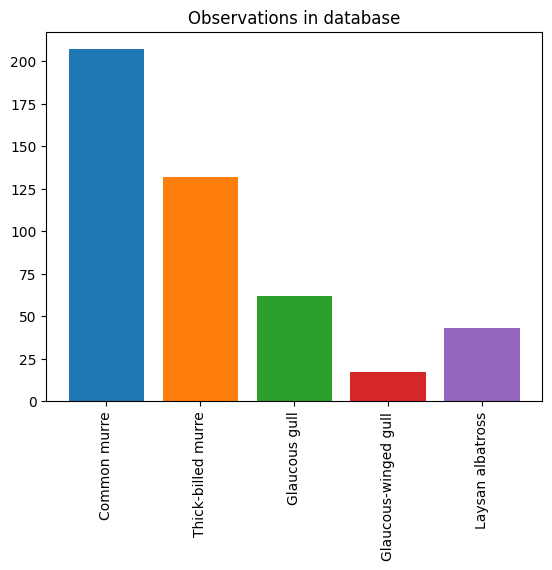

In [34]:
plt.bar(
    x=y.unique(),
    height=[np.sum(y==c) for c in y.unique()],
    color=['C0', 'C1', 'C2', 'C3', 'C4']
)
plt.title('Observations in database')
_ = plt.xticks(rotation=90)

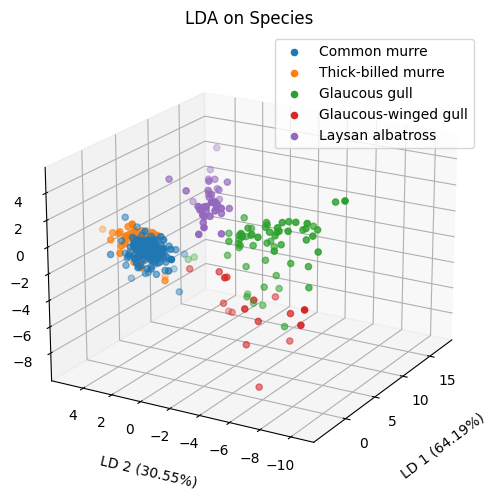

In [37]:
%matplotlib inline

ss = StandardScaler()
lda = LDA(n_components=3, store_covariance=True)
X_proj = lda.fit_transform(ss.fit_transform(X), y)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for bird in y.unique():
    mask = y == bird
    ax.scatter(X_proj[mask,0], X_proj[mask,1], X_proj[mask,2], label=bird)
ax.set_xlabel('LD 1 ({}%)'.format('%.2f'%(lda.explained_variance_ratio_[0]*100)),
              labelpad=16)
ax.set_ylabel('LD 2 ({}%)'.format('%.2f'%(lda.explained_variance_ratio_[1]*100)),
              labelpad=12)
ax.set_zlabel('LD 3 ({}%)'.format('%.2f'%(lda.explained_variance_ratio_[2]*100)),
              labelpad=12)
ax.set_title('LDA on Species')
ax.view_init(elev=20., azim=-150)

ax.tick_params(axis='x', which='major')
ax.tick_params(axis='y', which='major')
ax.tick_params(axis='z', which='major')
ax.legend(loc='best')

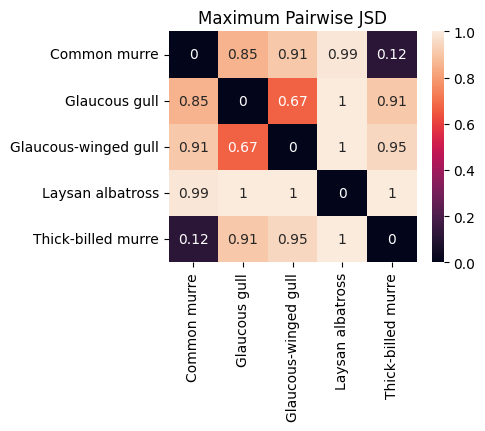

In [38]:
# Unfortunately, the murre species are essentially indistinguishable - these congeneric species "flock together" and
# they are not separable by the chemical data collected here.  This is why the species above seem to overlap in 3D space.

%matplotlib inline

jsb = JSBinary(js_bins=25, robust=False)
_ = jsb.fit(X, y)

fig, ax1 = plt.subplots(figsize=(4,3))

ax = jsb.visualize(ax1)
ax.tick_params(axis='x', which='major')
ax.tick_params(axis='y', which='major')
_ = ax.set_title('Maximum Pairwise JSD')

In [39]:
# The feature that has the biggest difference in distribution betweent the 2 murre species in PCB 206.
jsb.top_features(X.columns)

array([['NONE', 'PCB 110', 'PCB 110', 'mirex', 'PCB 206'],
       ['PCB 110', 'NONE', 'PCB 56', 'a-HCH', 'trans-chlordane'],
       ['PCB 110', 'PCB 56', 'NONE', 'PCB 52', 'PCB 110'],
       ['mirex', 'a-HCH', 'PCB 52', 'NONE', 'mirex'],
       ['PCB 206', 'trans-chlordane', 'PCB 110', 'mirex', 'NONE']],
      dtype=object)

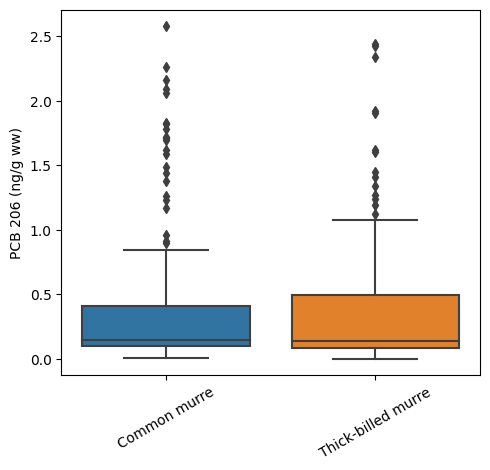

In [40]:
# And PCB 206 displays very minimal differences.

murre_mask = ['murre' in a for a in y.values]

X_net = X[murre_mask].copy()
X_net['species'] = y[murre_mask]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
for i,(a,ax) in enumerate(zip(
    ['PCB 206'],
    [axes]
)):
    ax_ = sns.boxplot(x='species', y=a, data=X_net, ax=ax, )
    _ = ax_.set_xticklabels(ax_.get_xticklabels(),rotation=30)
    _ = ax_.set_ylabel(a+' (ng/g ww)')
plt.tight_layout()
_ = ax_.set_xlabel('')

# Modeling Colony

Label the Data
---

In [41]:
X = pd.DataFrame(data=data_bunch['data'], columns=data_bunch['feature_names'], dtype=np.float64)
y = pd.Series(data=data_bunch['target'][:,1])

Examine the Class Imbalance
---

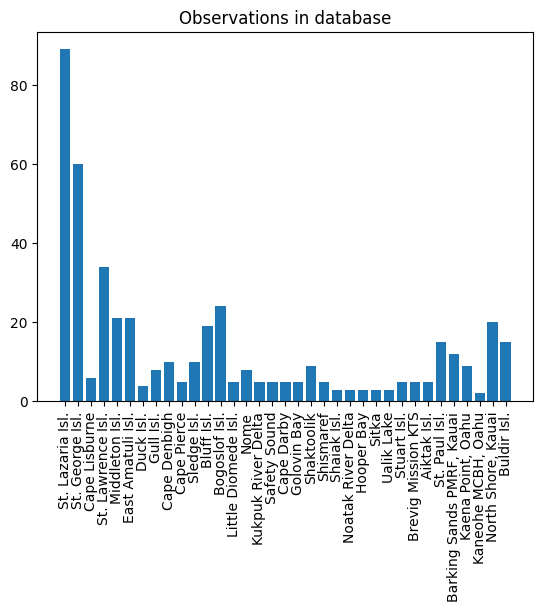

In [42]:
plt.bar(
    x=y.unique(),
    height=[np.sum(y==c) for c in y.unique()],
)
plt.title('Observations in database')
_ = plt.xticks(rotation=90)

In [43]:
# Let's focus on modeling those with at least 10 observations.
min_obs = 10
top_colonies = sorted([(k,v) for k,v in zip(*np.unique(y, return_counts=True)) if v >= min_obs], key=lambda x:x[1], reverse=True)

top_colonies

[('St. Lazaria Isl.', 89),
 ('St. George Isl.', 60),
 ('St. Lawrence Isl.', 34),
 ('Bogoslof Isl.', 24),
 ('East Amatuli Isl.', 21),
 ('Middleton Isl.', 21),
 ('North Shore, Kauai', 20),
 ('Bluff Isl.', 19),
 ('Buldir Isl.', 15),
 ('St. Paul Isl.', 15),
 ('Barking Sands PMRF, Kauai', 12),
 ('Cape Denbigh', 10),
 ('Sledge Isl.', 10)]

In [44]:
top_colonies = set([c[0] for c in top_colonies])
colony_mask = np.array([c in top_colonies for c in y])

Correlation between Species and Colony
---

Certain species of bird nest at certain locations, so it is expected that birds will not be evenly distributed.  In fact, it turns out that the colonies which are predominantly sampled are (unsurprisingly) mostly murre colonies.  Since we have observed very little difference between the murre species themselves, we can combine the murre colonies (regardless of which murre) to make a new dataset.  This contains only murre data so it should be free from bias coming from differences which naturally arise between different species.

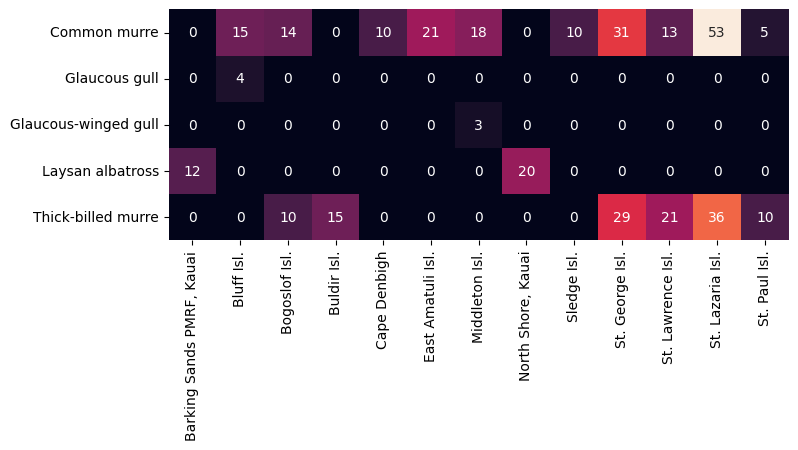

In [45]:
name_enc = LabelEncoder()
name_enc.fit(data_bunch['target'][:,2][colony_mask])

col_enc = LabelEncoder()
col_enc.fit(data_bunch['target'][:,1][colony_mask])

matrix = np.zeros((len(name_enc.classes_),len(col_enc.classes_)))

for cl_, nm_ in data_bunch['target'][colony_mask, 1:3]:
    matrix[name_enc.transform([nm_])[0], col_enc.transform([cl_])[0]] += 1

fig = plt.figure(figsize=(8,3))
_ = sns.heatmap(
    matrix,
    annot=True,
    ax=fig.gca(),
    cbar=False,
    xticklabels=col_enc.classes_,
    yticklabels=name_enc.classes_
)

In [46]:
# Only albatross nest in Hawaii, and gulls are poorly sampled here.  Let's drop those colonies.
top_colonies.discard('Barking Sands PMRF, Kauai')
top_colonies.discard('North Shore, Kauai')

top_colonies

{'Bluff Isl.',
 'Bogoslof Isl.',
 'Buldir Isl.',
 'Cape Denbigh',
 'East Amatuli Isl.',
 'Middleton Isl.',
 'Sledge Isl.',
 'St. George Isl.',
 'St. Lawrence Isl.',
 'St. Lazaria Isl.',
 'St. Paul Isl.'}

In [47]:
# Let's just take the top murre colonies (>=10 observations)
colony_mask = np.array([c in top_colonies for c in data_bunch['target'][:,1]])
species_mask = np.array(['murre' in name for name in data_bunch['target'][:,2]])

overall_mask = species_mask & colony_mask

In [48]:
X_murre = X[overall_mask]
y_murre = y[overall_mask]

What Makes A Colony Unique?
---

In [49]:
# Let's try use the JSD to distinguish murre colonies from each other.

screen = JSScreen(
    n=1, # Take the top analyte
    feature_names=X_murre.columns,
    js_bins=25
)
_ = screen.fit(X_murre, y_murre)

100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


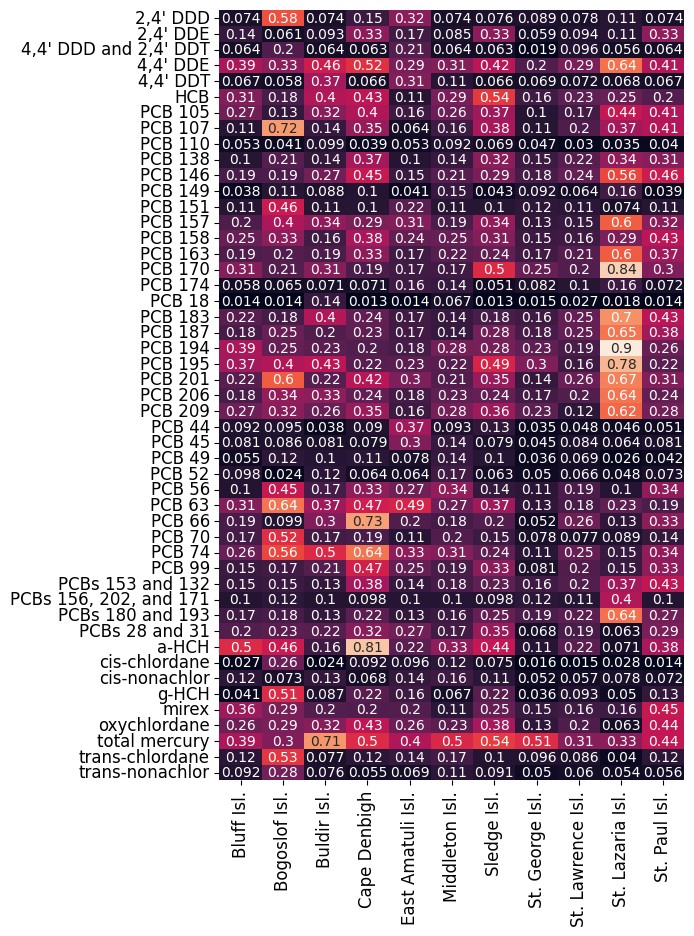

In [50]:
screen.visualize_grid(plt.figure(figsize=(6,10)).gca())
plt.title('')
plt.gca().tick_params(axis='x', which='major', labelsize=tick_size, rotation=90)
plt.gca().tick_params(axis='y', which='major', labelsize=tick_size)

Total mercury has the highest row average, but there are also unique things like a-HCH and PCB 194 which distinguish Cape Denbigh and St. Lazaria Isl. from others.  These analytes might show some interesting trends and be useful for fingerprinting murre colonies.

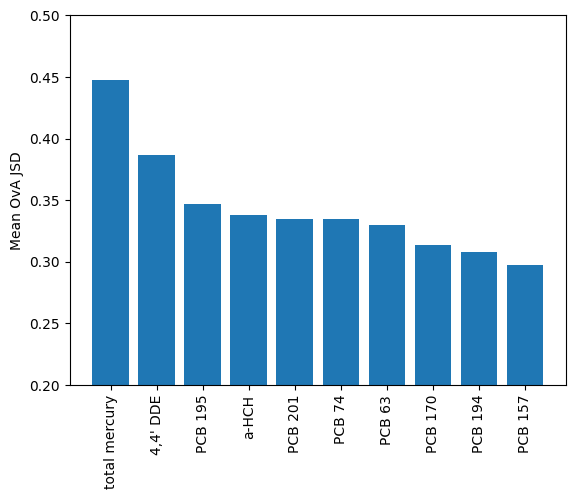

In [51]:
mean_ova_jsd = sorted(zip(X_murre.columns, np.mean(screen.grid, axis=1)), key=lambda x:x[1], reverse=True)

plt.bar(
    x=[a[0] for a in mean_ova_jsd][:10],
    height=[a[1] for a in mean_ova_jsd][:10]
)
_ = plt.xticks(rotation=90)
plt.ylabel('Mean OvA JSD')
_ = plt.ylim(0.2,.5)

In [52]:
def plot_analyte(analyte, X, y):
    X_net = X.copy()
    X_net['colony'] = y

    g = X_net.groupby('colony')
    order = g[analyte].mean().sort_values(ascending=True).index

    ax = sns.boxplot(
        x='colony',
        y=analyte,
        data=X_net,
        order=order,
    )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

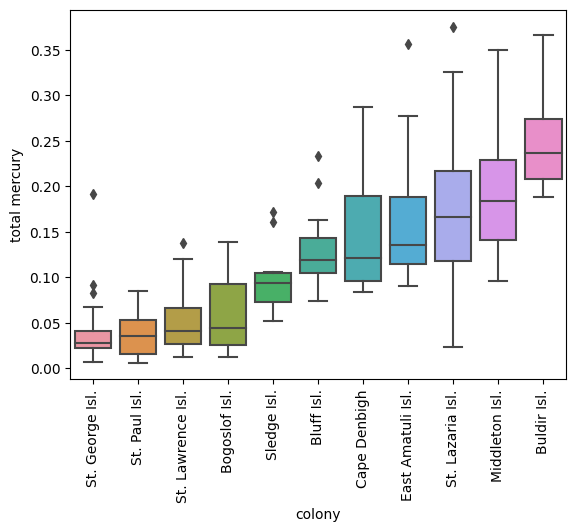

In [53]:
plot_analyte('total mercury', X_murre, y_murre)

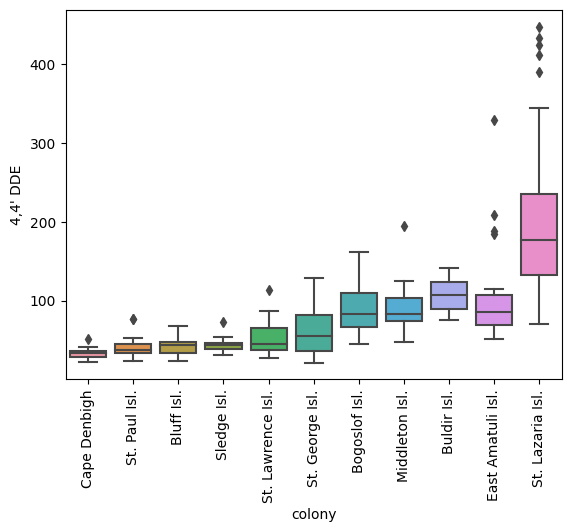

In [56]:
plot_analyte("4,4' DDE", X_murre, y_murre)

A Predictive Model
---

<h3>Examine Correlations Between Analytes</h3>

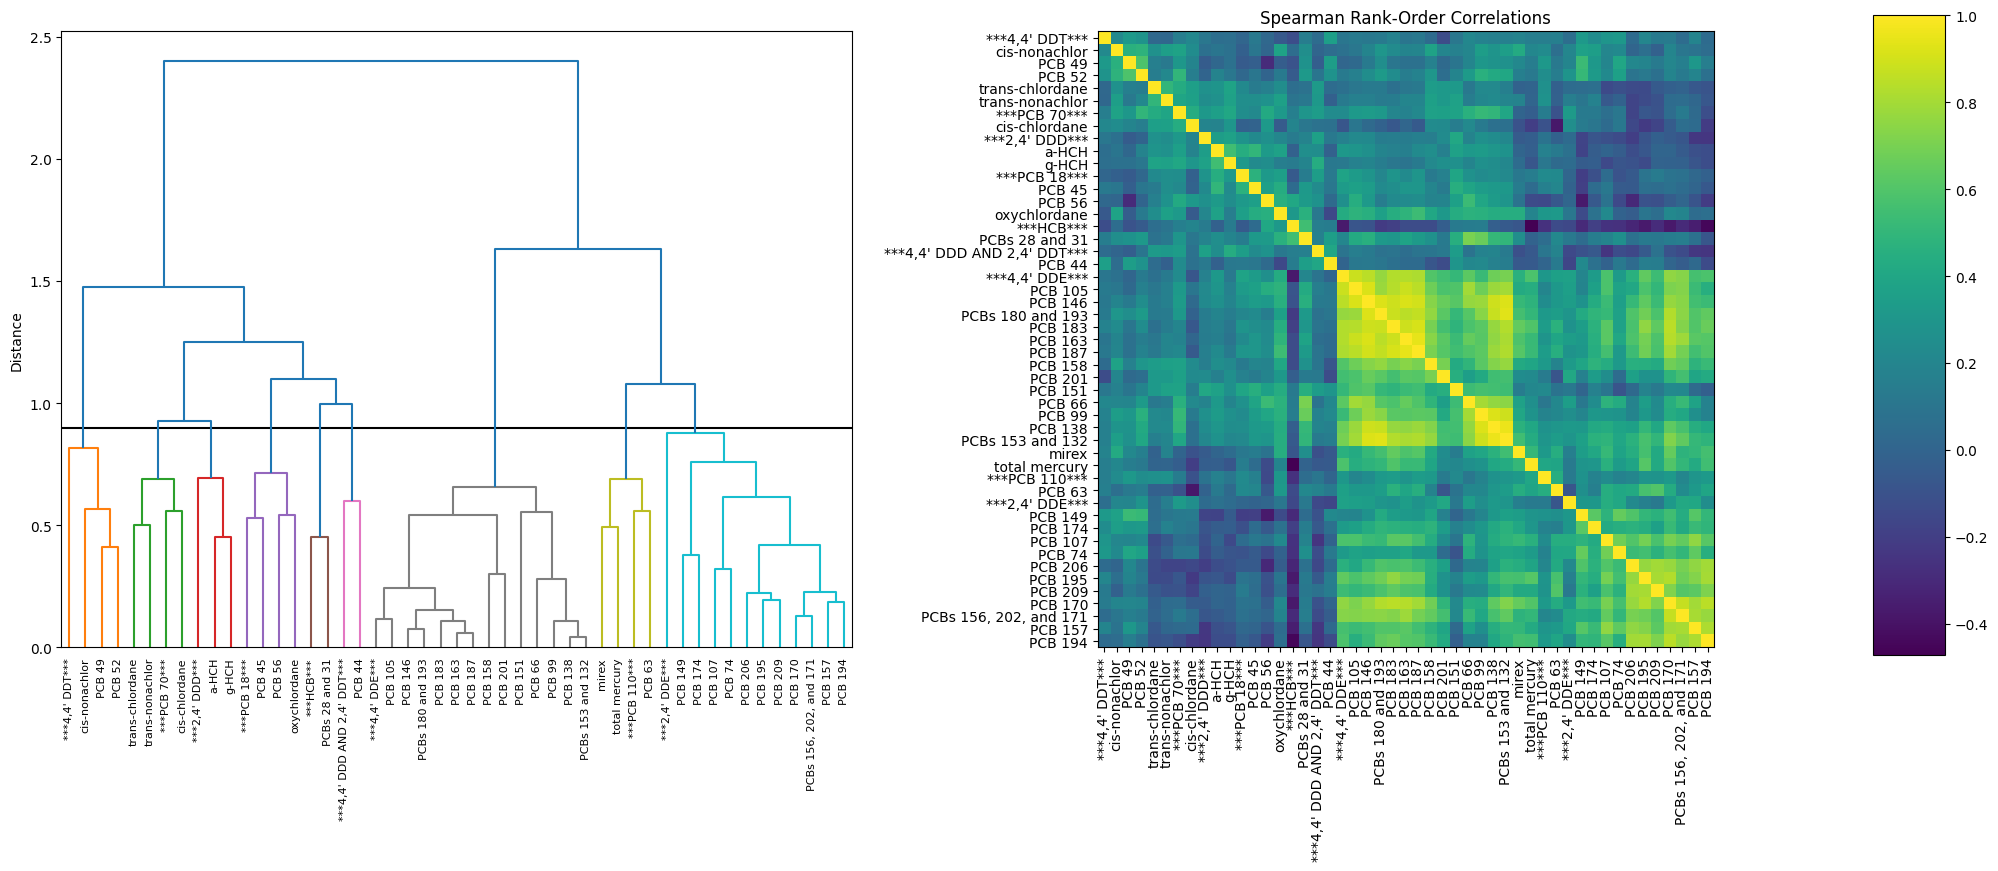

In [60]:
# Observe how most PCBs are correlated, as are other analytes that are similar to each other.
selected_features, cluster_id_to_feature_ids, _, dist_linkage = InspectData.cluster_collinear(
    X=X_murre.values,
    feature_names=X_murre.columns,
    t=0.9,
    figsize=(24,8),
    display=True,
    return_linkage=True
)

<h3>Build a Model</h3>

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X_murre,
    y_murre,
    test_size=0.2,
    random_state=0,
    stratify=y_murre,
    shuffle=True
)

In [62]:
def train_rf(t):
    # Decorrelate features for selection
    pipeline = imblearn.pipeline.Pipeline(
        steps=[
            ("feature_selector", SelectFromModel(
                    estimator=CollinearFeatureSelector(
                        t=t,
                        seed=42,
                        minimize_label_entropy=False,
                    ),
                    threshold=0.5,
                    prefit=False,
                )
            ),
            ("rf", RandomForestClassifier(
                random_state=42,
                class_weight='balanced',
                criterion='entropy'
            ))
        ]
    )

    param_grid ={
        'rf__n_estimators':np.linspace(10, 500, 20, dtype=np.int32),
        'rf__criterion':["gini", "entropy"],
    }

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        refit=True, # Refit on all the data
        cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    )

    _ = gs.fit(X_train, y_train)

    return gs

def check(model):
    used = model.best_estimator_.named_steps['feature_selector'].get_feature_names_out(X_murre.columns)
    print(f'{len(used)} total features used: {used}')

    print(f'Train Set Acc: {model.score(X_train, y_train)}')
    print(f'Test Set Acc: {model.score(X_test, y_test)}')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    disp = ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=axes[0], colorbar=False)
    disp.ax_.tick_params(axis='x', which='major', rotation=90)
    axes[0].set_title('Training Set')

    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[1], colorbar=False)
    disp.ax_.tick_params(axis='x', which='major', rotation=90)
    axes[1].set_title('Test Set')

    plt.tight_layout()

49 total features used: ["2,4' DDD" "2,4' DDE" "4,4' DDD and 2,4' DDT" "4,4' DDE" "4,4' DDT" 'HCB'
 'PCB 105' 'PCB 107' 'PCB 110' 'PCB 138' 'PCB 146' 'PCB 149' 'PCB 151'
 'PCB 157' 'PCB 158' 'PCB 163' 'PCB 170' 'PCB 174' 'PCB 18' 'PCB 183'
 'PCB 187' 'PCB 194' 'PCB 195' 'PCB 201' 'PCB 206' 'PCB 209' 'PCB 44'
 'PCB 45' 'PCB 49' 'PCB 52' 'PCB 56' 'PCB 63' 'PCB 66' 'PCB 70' 'PCB 74'
 'PCB 99' 'PCBs 153 and 132' 'PCBs 156, 202, and 171' 'PCBs 180 and 193'
 'PCBs 28 and 31' 'a-HCH' 'cis-chlordane' 'cis-nonachlor' 'g-HCH' 'mirex'
 'oxychlordane' 'total mercury' 'trans-chlordane' 'trans-nonachlor']
Train Set Acc: 1.0
Test Set Acc: 0.8412698412698413


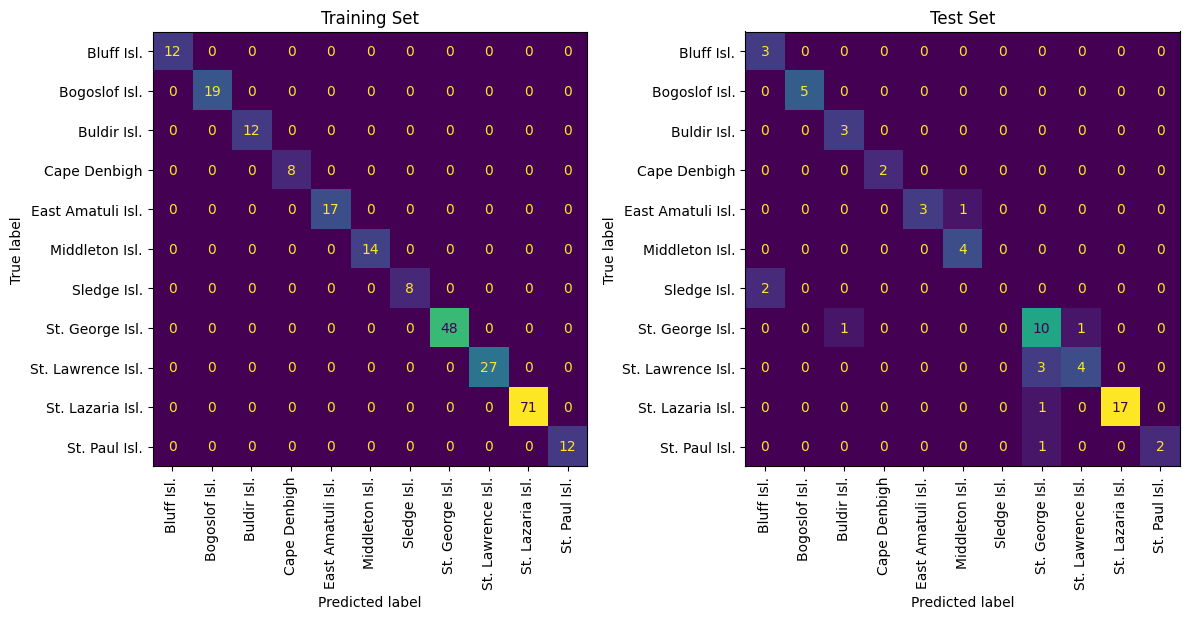

In [63]:
# This model selects all 49 features to build a model with
large_model = train_rf(t=0.0)

check(large_model)

9 total features used: ["4,4' DDD and 2,4' DDT" 'HCB' 'PCB 110' 'PCB 138' 'PCB 206' 'PCB 52'
 'g-HCH' 'oxychlordane' 'trans-chlordane']
Train Set Acc: 1.0
Test Set Acc: 0.6031746031746031


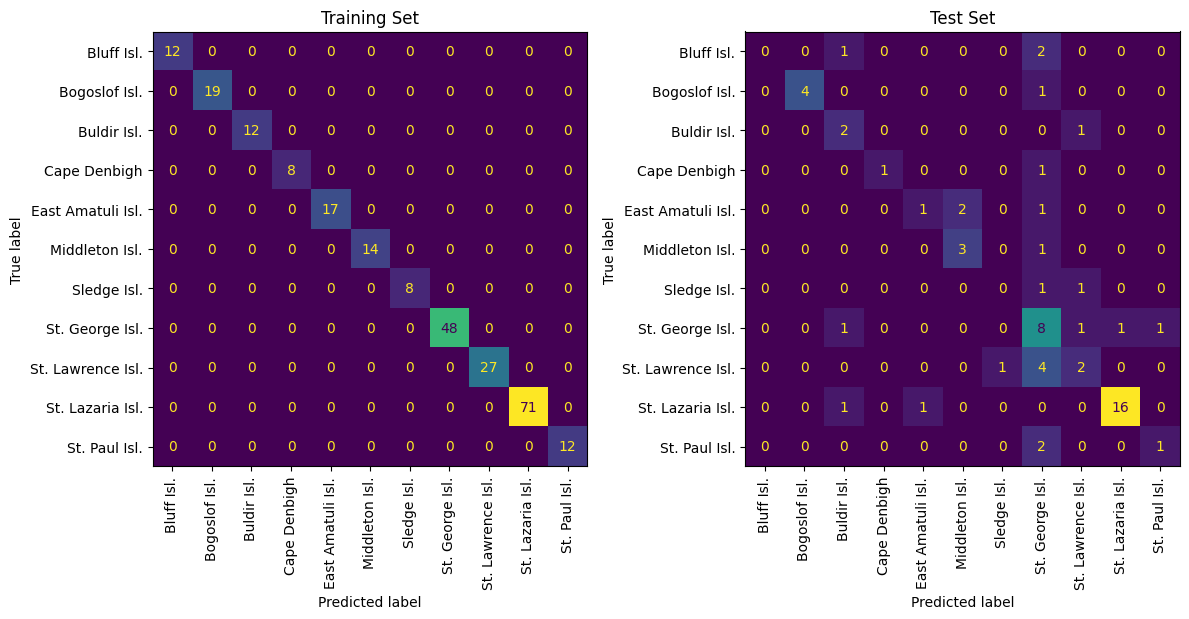

In [64]:
# This model selects 9 features to build a model with
medium_model = train_rf(t=0.9)

check(medium_model)

2 total features used: ['PCB 209' 'PCB 44']
Train Set Acc: 1.0
Test Set Acc: 0.3968253968253968


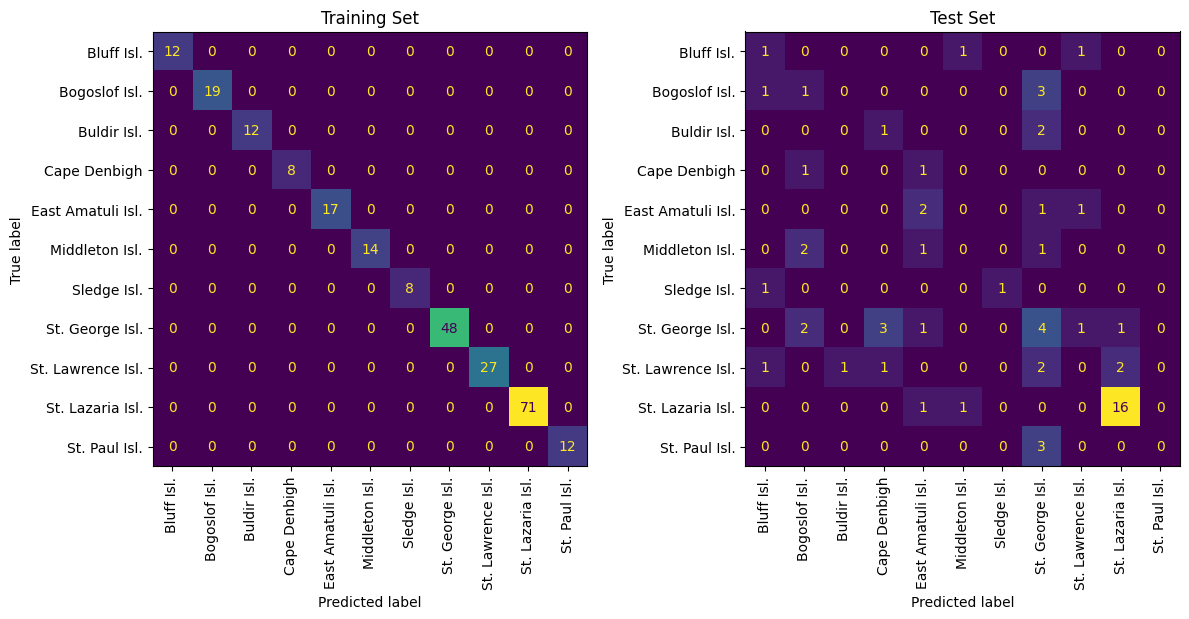

In [65]:
# This model selects 9 features to build a model with
small_model = train_rf(t=2.0)

check(small_model)

Although the medium model has average performance, the mistakes originate with colonies that are very close geographically.  As a result, this model is probably still capturing geogaphic information, just not enough to resolve very minute differences between nearby colonies.

In [66]:
import shap

In [67]:
X_train_df = pd.DataFrame(X_train, columns=X_murre.columns)
X_test_df = pd.DataFrame(X_test, columns=X_murre.columns)

correlated_background = shap.maskers.Partition(
    X_train_df,
    max_samples=100,
    clustering=dist_linkage
)

explainer = shap.Explainer(
    medium_model.predict_proba,
    correlated_background,
    algorithm="permutation"
)

In [68]:
# Let's just look at the the training set for this example.
shap_values_train = explainer(X_train_df)

PermutationExplainer explainer: 249it [10:08,  2.45s/it]


In [69]:
# For X = 248 x 49 matrix we have 11 categories.
shap_values_train.values.shape

(248, 49, 11)

In [70]:
# Average abs(shap) across all colonies and all samples to get average impact of each analyte.
ave_shap_train = np.mean(np.abs(shap_values_train.values), axis=(0,2))

In [71]:
# Observe that because of feature selection (9 selected) the unselected features (40) have no impact, as expected.
ave_shap_train

array([0.        , 0.        , 0.02052581, 0.        , 0.        ,
       0.03459958, 0.        , 0.        , 0.01543543, 0.01960699,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04272941,
       0.        , 0.        , 0.        , 0.        , 0.01033833,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01291254, 0.        ,
       0.01381122, 0.        , 0.01023933, 0.        ])

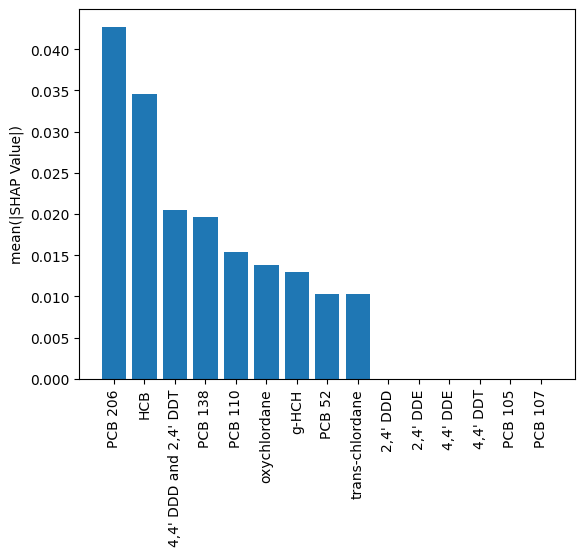

In [72]:
shap_importances = sorted(zip(X_murre.columns, ave_shap_train), key=lambda x:x[1], reverse=True)[:15]

plt.bar(
    x=[a[0] for a in shap_importances],
    height=[a[1] for a in shap_importances]
)
plt.ylabel('mean(|SHAP Value|)')
_ = plt.xticks(rotation=90)

In this example we have taken features somewhat ad-hoc; in the manuscript cited above additional subject matter expertise was factored in.  Regardless, here PCB 206 behaves like PCB 194 (from the manuscript) in that it distinguishes St. Lazaria from the other colonies, while the other most significant feature shows a general trend across colonies (in the manuscript this was total mercury - which indeed, yields a better model than the one presented here).  Thus, the model is using 1 feature to distinguish St. Lazaria; if a sample is not from there then the other feature(s) help the model determine which one.

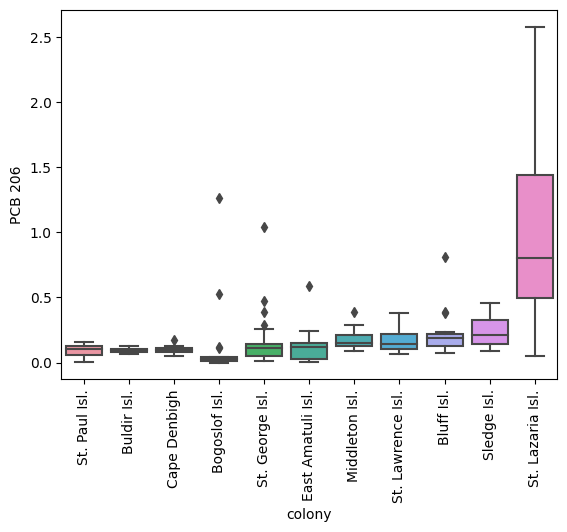

In [73]:
plot_analyte("PCB 206", X_murre, y_murre)

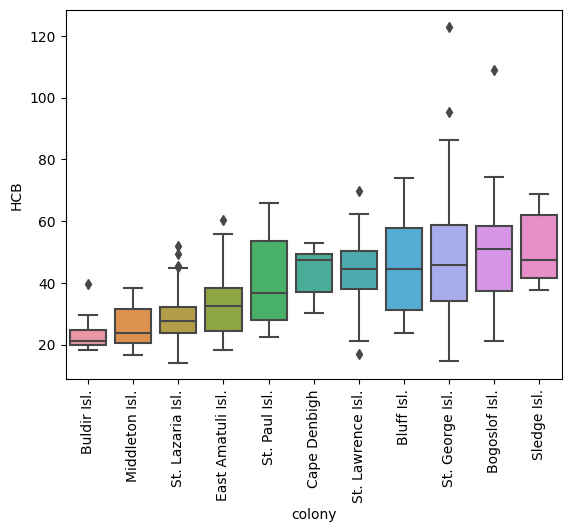

In [74]:
plot_analyte("HCB", X_murre, y_murre)

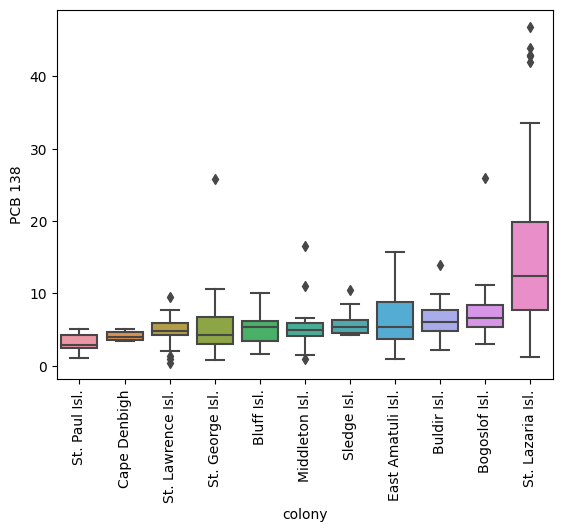

In [75]:
plot_analyte("PCB 138", X_murre, y_murre)